# Inital data analysis of the virtual screening results

This notebook does some general data anslysis on the virtual screening results.

It uses the output of the 1_DataPrep.ipynb notebook for it's data. 

In [19]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import os, glob, gzip

In [20]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

In [21]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [22]:
# Currently can't work out how to read the pickle correctly so we read the SDF instead
df = PandasTools.LoadSDF('./Mpro_16_data.sdf.gz', molColName='Molecule')
df.shape

(41582, 13)

In [23]:
df.dtypes

Target                        object
TransFSScore                  object
SCORE                         object
SCORE.norm                    object
Max_SuCOS_Score               object
Max_SuCOS_FeatureMap_Score    object
Max_SuCOS_Protrude_Score      object
Max_SuCOS_Index               object
Cum_SuCOS_Score               object
Cum_SuCOS_FeatureMap_Score    object
Cum_SuCOS_Protrude_Score      object
ID                            object
Molecule                      object
dtype: object

In [37]:
# So we need to fix all the column types again!

df = df.astype(dtype= {
    "Cum_SuCOS_FeatureMap_Score":"float64",
    "Cum_SuCOS_Protrude_Score":"float64",
    "Cum_SuCOS_Score":"float64",
    "Max_SuCOS_Index":"float64",
    "Max_SuCOS_FeatureMap_Score":"float64",
    "Max_SuCOS_Protrude_Score":"float64",
    "Max_SuCOS_Score":"float64",
    "SCORE":"float64",
    "SCORE.norm":"float64",
    "TransFSScore":"float64"
})
df =  df.astype(dtype= {
    "Max_SuCOS_Index":"int64",
})

df = df.rename(columns={"ID": "NSMILES"})

,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,Cum_SuCOS_Score,Cum_SuCOS_FeatureMap_Score,Cum_SuCOS_Protrude_Score,NSMILES,Molecule
0,Mpro-x0678,0.162173,-14.4733,-1.31576,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,BrC(Br)=Cc1ccc(Br)cc1,
1,Mpro-x0104,0.078375,-30.9106,-3.09106,0.284089,0.024352,0.543826,13,2.078812,0.424377,3.733246,BrC(Br)=Cc1ccncn1,
2,Mpro-x0104,0.076633,-33.4132,-3.34132,0.317920,0.179804,0.456035,2,2.072300,0.394161,3.750438,BrC(Br)=Cc1cncnc1,
3,Mpro-x1249,0.178053,-15.4443,-0.90849,0.434434,0.151883,0.716986,13,3.900913,1.153626,6.648199,BrC(CCC1CCCCC1)Cc1ccccn1,
4,Mpro-x0678,0.431011,-23.7233,-1.39549,0.308991,0.099810,0.518171,8,3.210272,0.578760,5.841785,BrC(CCC1CCCCC1)Cc1ccncc1,

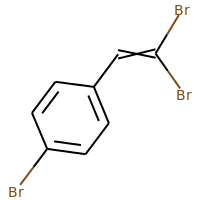
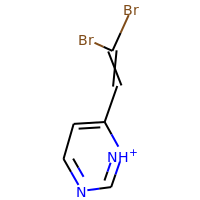
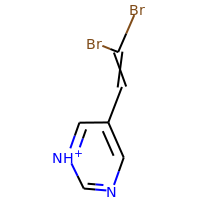
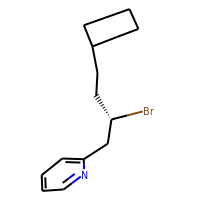
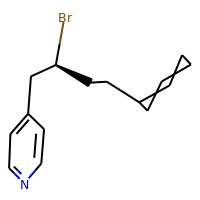

In [38]:
df.head()

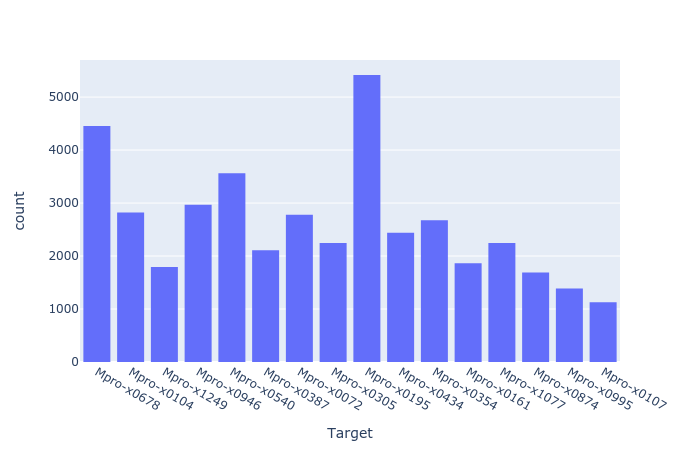

In [39]:
# Let's look at which targets the best TransFSScoring poses came from
fig = px.histogram(df, x="Target")
fig.show()

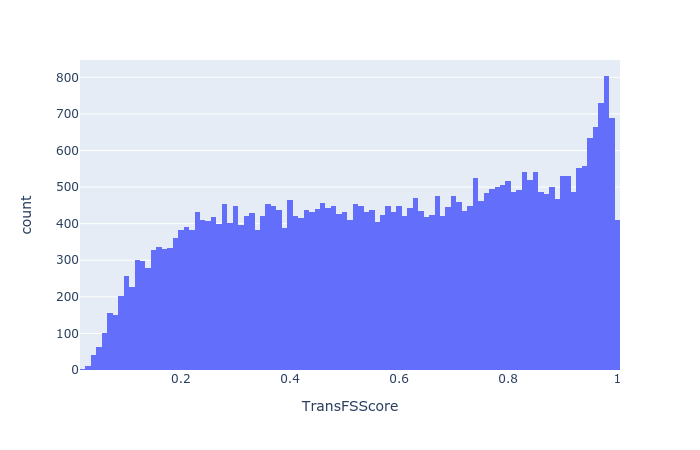

In [40]:
# Let's look at the distribution of TransFSSCores
fig = px.histogram(df, x="TransFSScore")
fig.show()

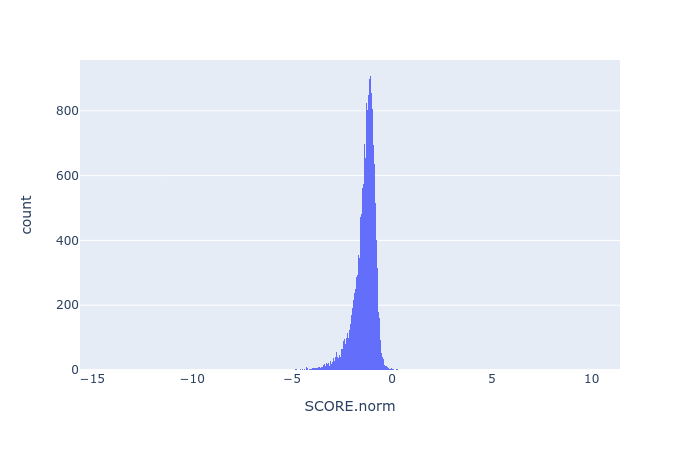

In [41]:
# Let's look at the distribution of normalised docking scores.
# The more negative the number the better.
fig = px.histogram(df, x="SCORE.norm")
fig.show()

# these cluster around -2 but there are wild outliers

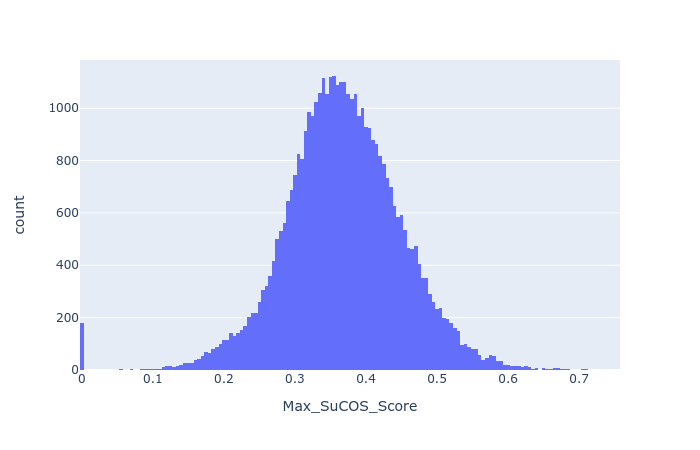

In [42]:
# Let's look at the distribution of Max_SuCOS_Score scores
fig = px.histogram(df, x="Max_SuCOS_Score")
fig.show()
# Susan's rule of thumb is that anything above 0.5 is 'reasonable'.

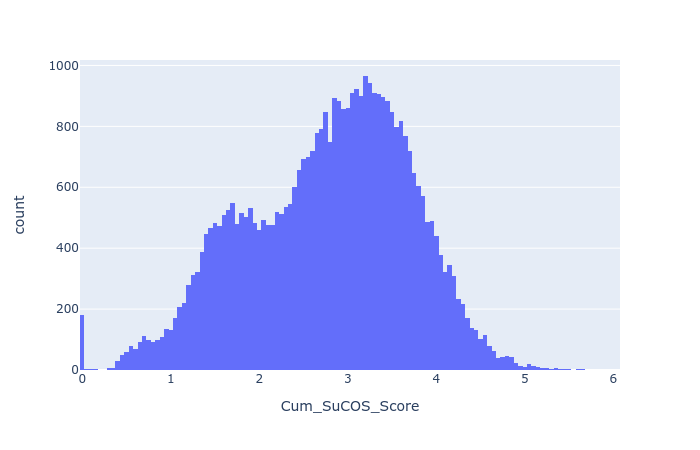

In [43]:
# Let's look at the distribution of Cum_SuCOS_Score scores.
# These might be more useful than the Max_SuCOS_Score as it includes overlap with all hit ligands?
fig = px.histogram(df, x="Cum_SuCOS_Score")
fig.show()

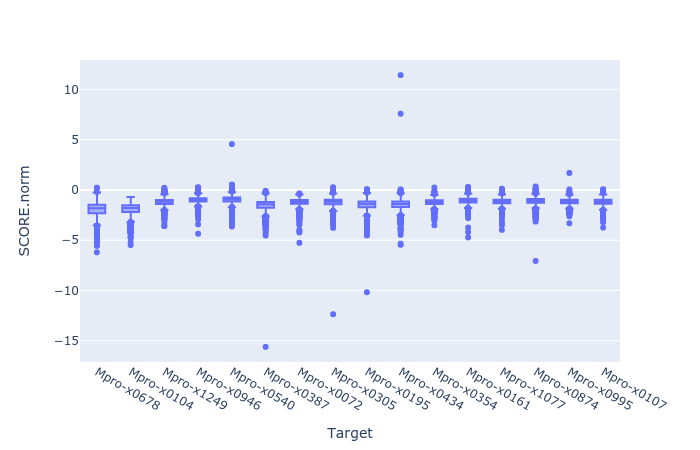

In [44]:
# Let's check the distribution of normalised docking scrores across the targets.
# Low (negative) scores are better.
fig = px.box(df, x="Target", y="SCORE.norm")
fig.show()

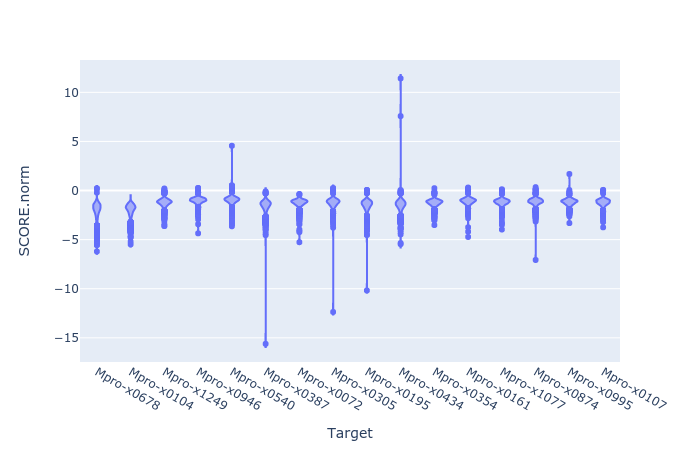

In [45]:
# You can instead use a violin plot for a different view of this
fig = px.violin(df, x="Target", y="SCORE.norm")
fig.show()

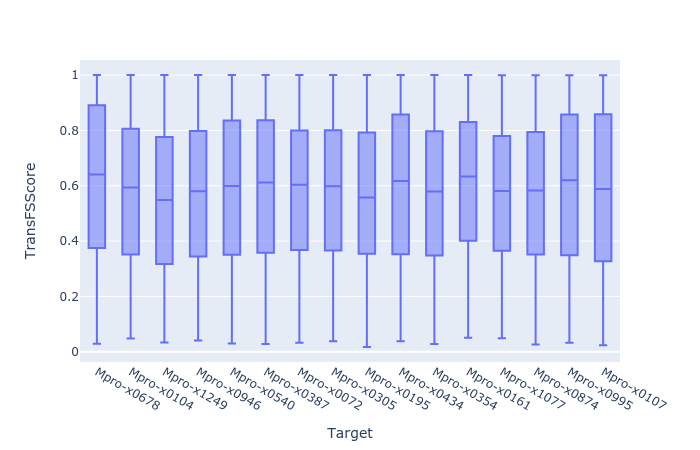

In [46]:
# Now the TransFSScore
fig = px.box(df, x="Target", y="TransFSScore")
fig.show()

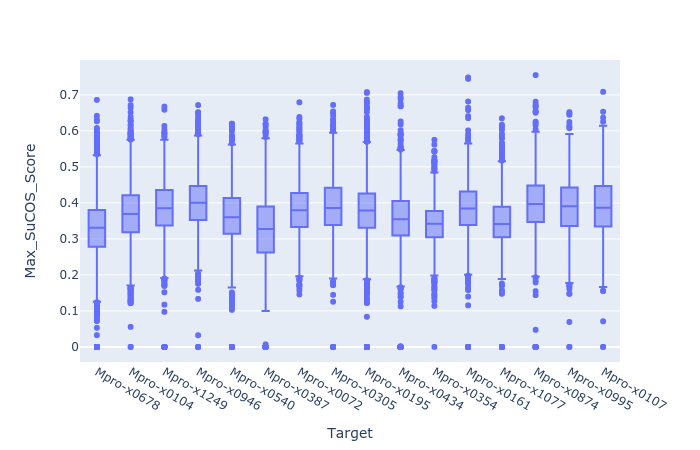

In [47]:
# And the Max_SuCOS_Score
fig = px.box(df, x="Target", y="Max_SuCOS_Score")
fig.show()

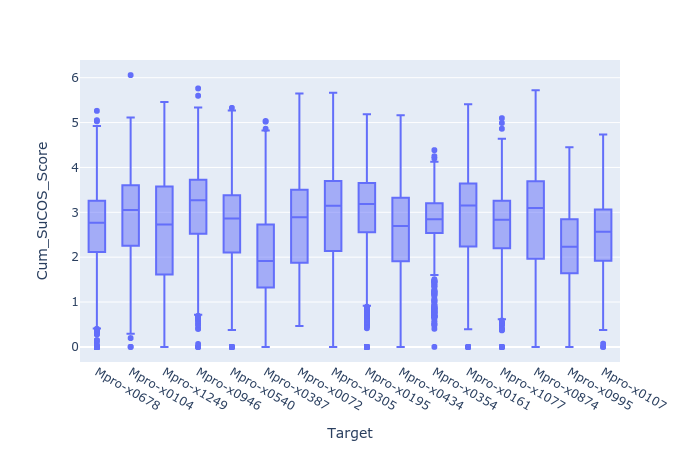

In [48]:
# And the Cum_SuCOS_Score
fig = px.box(df, x="Target", y="Cum_SuCOS_Score")
fig.show()

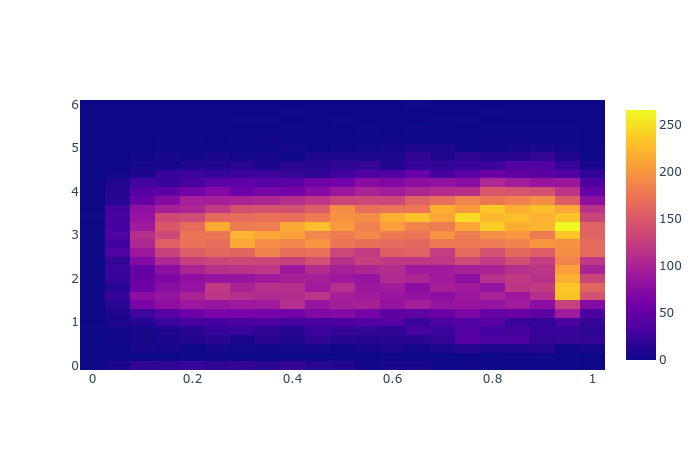

In [49]:
# Let's see how the TransFSScore compare with the Cum_SuCOS_Score.
fig = go.Figure(go.Histogram2d(
        x=df['TransFSScore'],
        y=df['Cum_SuCOS_Score']
    ))
fig.show()
# Not much of a correlation. But that's not too surprising and may be good if we use both to filter 
# as they are orthoganal.

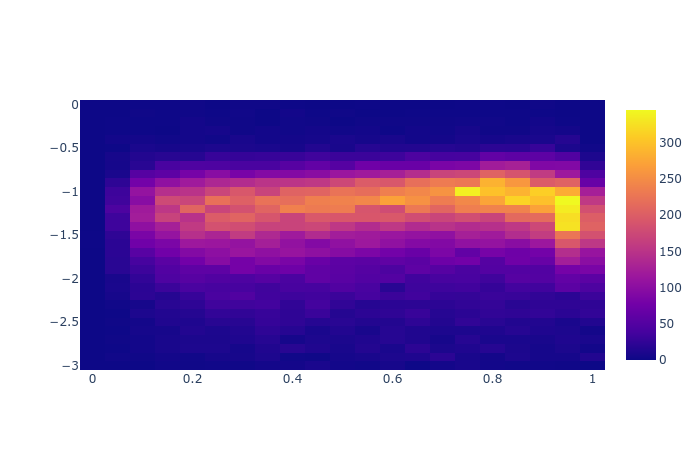

In [50]:
# How about correlation of TransFSScore with normalised docking score
# We need to filter the docking score because of the outliers
filtered_df = df[(df['SCORE.norm'] < 0) & (df['SCORE.norm'] > -3)]
fig = go.Figure(go.Histogram2d(
        x=filtered_df['TransFSScore'],
        y=filtered_df['SCORE.norm']
    ))
fig.show()
# No real correlation visible 

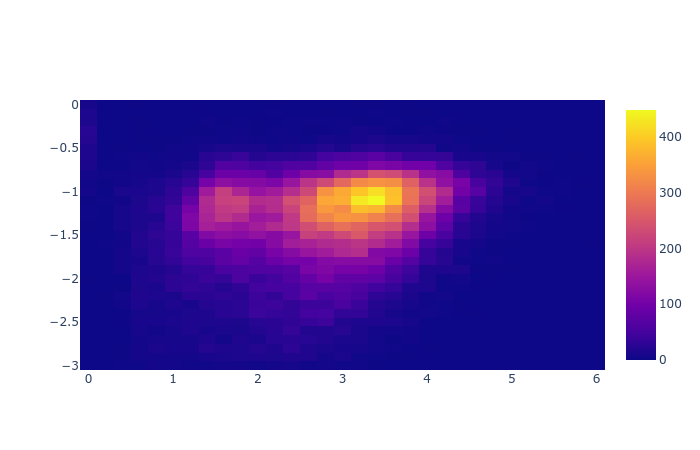

In [51]:
# How about correlation of Cum_SuCOS_Score with normalised docking score
# We need to filter the docking score because of the outliers
filtered_df = df[(df['SCORE.norm'] < 0) & (df['SCORE.norm'] > -3)]
fig = go.Figure(go.Histogram2d(
        x=filtered_df['Cum_SuCOS_Score'],
        y=filtered_df['SCORE.norm'],
    ))
fig.show()
# No real correlation visible